# Set up keras with tensorflow-gpu backend

In [10]:
import keras
import pandas as pd
import numpy as np
from tensorflow.python.client import device_lib
import math
import dateutil.parser
import matplotlib.pyplot as plt
print(device_lib.list_local_devices())
data = pd.read_csv(r'C:\Users\Ido\Desktop\datasets\patient_no_show\noshowdata.csv')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12848505356042650171
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 235923046
locality {
  bus_id: 1
}
incarnation: 2886235954665343136
physical_device_desc: "device: 0, name: GeForce 940M, pci bus id: 0000:06:00.0, compute capability: 5.0"
]


# Feature Engineering

In [11]:
#First, let's look at the data. Most features are binary coded.
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [303]:
data['PatientId'] = data.apply(lambda x:str(x['PatientId']),axis=1)
data[:5]
#Age, Gender, ScheduledDay and AppointmentDay, Neighbourhood all need some work to extract valuable information

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,age_code,app_day_code,sch_day_code,time_diff,time_diff_code
0,29872499824296.0,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,6,4,4,0,1
1,558997776694438.0,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,1,6,4,4,0,1
2,4262962299951.0,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,6,4,4,0,1
3,867951213174.0,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,2,4,4,0,1
4,8841186448183.0,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,6,4,4,0,1


In [298]:
#Let's make the No-show and Gender factors binary
data['no_show'] = data.apply(lambda x:int(x['No-show']=='Yes'),axis=1)
data['is_male'] = data.apply(lambda x:int(x['Gender']=='M'),axis=1)


#And drop the original columns
data = data.drop(columns=['Gender'],axis=0)
data = data.drop(columns=['No-show'],axis=0)

KeyError: ('No-show', 'occurred at index 0')

## Age 

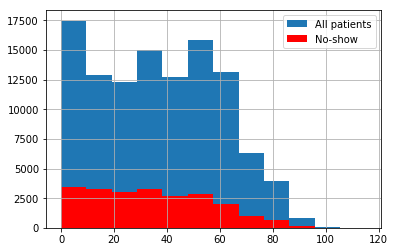

<Figure size 432x288 with 0 Axes>

In [14]:
data = data[data['Age']>=0]
#Let's look at how the ages are distributed
ax = pd.Series(data['Age']).hist(bins=12)
ax2 = pd.Series(data[['Age','no_show']][data['no_show']==1]['Age']).hist(bins=12,color='red')
ax.legend(['All patients','No-show'])
plt.figure()
plt.show()


Most patients are younger than 60, other than that the data is balanced in terms of age.
Let's look the outliers




In [28]:
data[data['Age']>data['Age'].quantile(0.999)].describe()



,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male
count,1.030000e+02,1.030000e+02,103.000000,103.0,103.000000,103.000000,103.0,103.000000,103.000000,103.000000,103.000000
mean,1.549780e+14,5.664662e+06,96.572816,0.0,0.611650,0.145631,0.0,0.213592,0.213592,0.184466,0.300971
std,2.711258e+14,1.000629e+05,4.545202,0.0,0.489758,0.354461,0.0,0.456983,0.411846,0.389760,0.460923
min,3.661577e+10,5.284772e+06,94.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,7.116072e+12,5.626168e+06,94.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,3.918266e+13,5.681315e+06,95.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,9.704159e+13,5.729392e+06,97.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,9.893967e+14,5.789013e+06,115.000000,0.0,1.000000,1.000000,0.0,2.000000,1.000000,1.000000,1.000000


These look like legitimate data, nevertheless they won't give enough information to be valueable.
I'll remove ages over 100


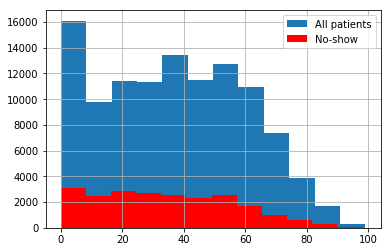

<Figure size 432x288 with 0 Axes>

In [29]:
data = data[data['Age']<100]
ax = pd.Series(data['Age']).hist(bins=12)
pd.Series(data[['Age','no_show']][data['no_show']==1]['Age']).hist(bins=12,color='red')
ax.legend(['All patients','No-show'])
ax.xlabel='Age'
plt.figure()
plt.show()

These functions will help me split continuous data into regions and graph their no_show rate

In [66]:
import numpy as np

#get_splits quantizes the data into bins
def get_splits(data, column, bins, method, base = 0.5):
    if (method == 'linear'):
        splits = np.linspace(data[column].min(),data[column].max(),bins+1)[:-1]
    if (method == 'quantile'):
        splits = data[column].quantile(np.linspace(0,1,bins+1)[:-1])
    if (method == 'pow'):
        splits = np.power(data[column].min()+ np.linspace(0,1,bins+1)[:-1], base)*data[column].max()
    if (method == 'pow-quantile'):
        splits = data[column].quantile(np.power(np.linspace(0,1,bins+1)[:-1], base))
    return splits

def analyze_splits(data, column, bins = 10, method = 'linear', base = 0.5):
    new_data =pd.DataFrame(data[[column,'no_show']])
    splits = get_splits(data,column,bins,method, base)
    
    new_data['code'] = np.digitize(data[column], splits)
    data_means = pd.DataFrame(pd.DataFrame(new_data).groupby('code').mean()) 

    plt.stem(data_means[column],data_means['no_show'])
    
    plt.ylabel('no_show')
    plt.xlabel('column')
    plt.show()
    return (splits,data_means)
    
#

Let's try to see how the no_show probability changes with the age

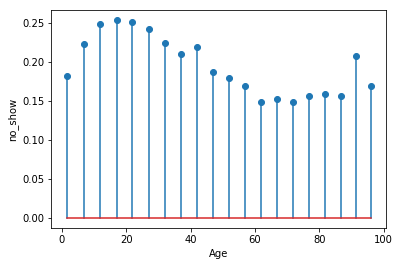

splits:
 [ 0.    4.95  9.9  14.85 19.8  24.75 29.7  34.65 39.6  44.55 49.5  54.45
 59.4  64.35 69.3  74.25 79.2  84.15 89.1  94.05]


means:
             Age   no_show
code                     
1      1.488381  0.182093
2      6.954238  0.223835
3     11.930128  0.249395
4     17.105256  0.253704
5     21.928092  0.251604
6     27.044863  0.241853
7     32.012641  0.224884
8     37.047675  0.210293
9     42.024522  0.219822
10    47.045800  0.186736
11    51.989885  0.179845
12    57.029912  0.169933
13    61.980948  0.149018
14    66.860333  0.152987
15    71.936328  0.149063
16    76.868636  0.155849
17    81.712656  0.158714
18    86.667976  0.156189
19    91.524496  0.207493
20    96.033898  0.169492


In [33]:

splits, means = analyze_splits(data,'Age',bins = 20, method='linear')
print('splits:\n',splits)
print('\n\nmeans:\n',means)

This doesn't give enough importance to young ages, we could skew quantization towards lower ages by splitting with power base
We also have more information for younger ages, so it makes sense to split it more often than sparse information

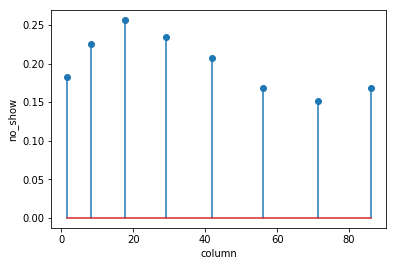

splits:
 [ 0.          4.37522321 12.375      22.73432668 35.00178567 48.91648256
 64.30238623 81.03026778]


means:
             Age   no_show
code                     
1      1.488665  0.182138
2      8.272854  0.225848
3     17.731373  0.256087
4     29.176072  0.234418
5     41.864431  0.207047
6     56.181417  0.167896
7     71.500209  0.151964
8     86.075178  0.167997


In [67]:
splits, means = analyze_splits(data,'Age',bins = 8, method= 'pow', base = 1.5)
print('splits:\n',splits)
print('\n\nmeans:\n',means)
#Age data is obviously significant. Young adults miss more appointments.

#We'd like to later split more often where there's more variance (ages 0-20 for example)


I could choose to simply code the ages according to the groups, and I'll try to do that.
But this will cause information loss because although group 5 should be similar to group 6 and 4, the model doesn't reflect that.

I could solve this by coding each of the age groups with its adjacent neighbours.

for example: a 26 year old is 20-30 but also a little 10-20 and a little 30-40


I could also pick significant points on the graph and calculate the proximity to each point

for example: ages 0, 23 and 70 are peaks. Coding for the proximity could give me the influence each age group has on the patient. A 40 year old will be similar to a 23 year old, but also similar to a 70 year old. A simple regression might suffice.


For now, I'll code the ages according to these thresholds (shown in splits) and later I'll decide on how to set the dummy-variables to account for group similarity


In [35]:
splits = get_splits(data,'Age',8,'pow', base = 1.5)
data['age_code'] = np.digitize(data['Age'],splits)
#data = data.drop(columns=['Age'])


## Date

The two time features are AppointmentDay and ScheduledDay.

1. Effects of the appointment day of the week (Sunday - Saturday) will be coded 0-6
2. Effects of the scheduling day of the week (Sunday - Saturday) will be coded 0-6
3. Time difference between scheduling and the appointment is in days (same day appointments are always -1)

Using the week of the year can give WEEKxDAY interaction, which can differentiate holidays or events.
But this will introduce a lot of complexity, so for now I'll refrain from using it.

In [36]:
seconds_in_day = 24*60*60
time_actions =[{'name': 'app_day_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).weekday())},
              {'name': 'sch_day_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).weekday())},
              #{'name': 'app_week_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).isocalendar()[1])},
              #{'name': 'sch_week_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).isocalendar()[1])},
              #{'name': 'app_year_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).year)},
              #{'name': 'sch_year_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).year)},
              {'name': 'time_diff', 'my_lambda' : lambda x:(int(math.floor((dateutil.parser.parse(x['AppointmentDay'])\
                                        - dateutil.parser.parse(x['ScheduledDay'])).total_seconds()/seconds_in_day+1)))}]

for action in time_actions:
    data[action['name']] = data.apply(action['my_lambda'],axis=1)
data = data[data['time_diff']>-1]

### Time Difference

Time difference is named 'time_diff' and represents the number of days between scheduling date and appointment date

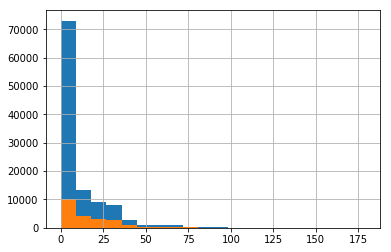

In [37]:
ax = pd.Series(data['time_diff']).hist(bins=20)
ax = pd.Series(data['time_diff'][data['no_show']==1]).hist(bins=20)
plt.show()

Most patients set their appointment on the day or week of the appointment
They also miss the appointment less often.
Let's first try to make sense of the outliers (125+ days)


In [38]:

data[data['time_diff']>100].describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,age_code,app_day_code,sch_day_code,time_diff
count,1.380000e+02,1.380000e+02,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,1.409606e+14,5.217599e+06,58.340580,0.072464,0.601449,0.152174,0.021739,0.072464,0.637681,0.297101,0.318841,5.978261,2.115942,1.637681,138.094203
std,2.460203e+14,7.821621e+04,25.012551,0.260199,0.491383,0.360498,0.146362,0.260199,0.482421,0.458646,0.467725,1.942485,1.250241,1.413914,27.995278
min,5.649478e+08,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,101.000000
25%,5.949659e+12,5.140264e+06,45.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,1.000000,110.000000
50%,3.766274e+13,5.226171e+06,66.500000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,2.000000,1.000000,133.000000
75%,9.162741e+13,5.283083e+06,77.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,7.000000,3.000000,3.000000,162.000000
max,9.965348e+14,5.392234e+06,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,4.000000,4.000000,179.000000


In [39]:
test_data = data[data['time_diff']>50]
test_data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,age_code,app_day_code,sch_day_code,time_diff
count,3.128000e+03,3.128000e+03,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000
mean,1.495421e+14,5.459402e+06,46.316816,0.043478,0.209719,0.070972,0.009910,0.019821,0.637148,0.303389,0.317136,5.114770,1.884910,2.003836,68.692775
std,2.580203e+14,8.073942e+04,24.031167,0.203964,0.407173,0.256819,0.099073,0.150440,0.480899,0.459795,0.465435,1.903475,1.478831,1.402400,18.947386
min,2.157787e+08,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,51.000000
25%,3.871774e+12,5.416665e+06,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,58.000000
50%,3.195894e+13,5.454654e+06,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,2.000000,2.000000,64.000000
75%,9.721134e+13,5.530621e+06,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,6.000000,3.000000,3.000000,72.000000
max,9.967713e+14,5.597360e+06,98.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,8.000000,4.000000,5.000000,179.000000


For 136 patients over 100 days, the no_show rate is 0.301
For 3100 patients over 50 days, the no_show rate is 0.303
With only 136 patients, this doesn't seem like a significant difference,
and these patients probably behave the same. For now I'll remove those outliers.


It seems that patients who schedule 100+ days ahead are older than patients who schedule 50+ days ahead.
This information is found in the model, so we're not missing out on data differentiating those "older, long-ahead appointments"



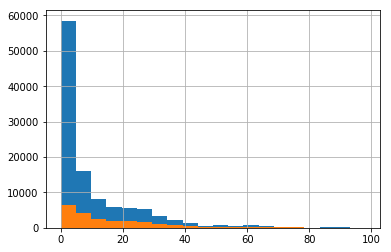

In [43]:
data = data[data['time_diff']<100]
ax = pd.Series(data['time_diff']).hist(bins=20)
ax = pd.Series(data['time_diff'][data['no_show']==1]).hist(bins=20)
plt.show()

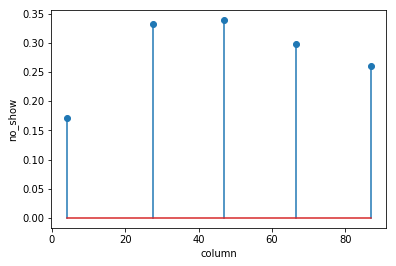

In [187]:
split,mean = analyze_splits(data,column = 'time_diff',bins =5,method = 'linear')


This certainly doesn't give enough attention to earlier days. Let's try a different scale

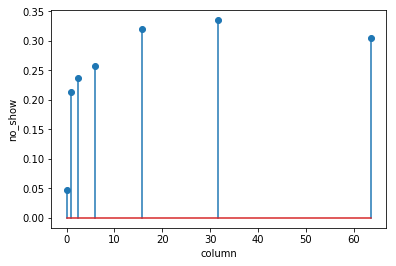

splits:
 [0.00000000e+00 2.27916679e-07 5.83466697e-05 1.49536133e-03
 1.49367474e-02 8.90299526e-02 3.82812500e-01 1.31389430e+00
 3.82380735e+00 9.81106567e+00 2.27916679e+01 4.88559642e+01]


means:
             Age   no_show
code                     
1      1.488665  0.182138
2      8.272854  0.225848
3     17.731373  0.256087
4     29.176072  0.234418
5     41.864431  0.207047
6     56.181417  0.167896
7     71.500209  0.151964
8     86.075178  0.167997


In [99]:
splits,mean = analyze_splits(data,column = 'time_diff',bins = 12,method = 'pow',base=8)
print('splits:\n',splits)
print('\n\nmeans:\n',means)

For better quantization, I could use an iterative algorithm

For now I'll use the given quantization above, but put all the same-day patients in a separate group 

In [109]:

splits = get_splits(data,'time_diff',bins = 5,method = 'pow', base = 2 )
splits = np.insert(splits,1,0.1)
data['time_diff_code'] = np.digitize(data['time_diff'],splits)

### Scheduled Day

Let's look at the no_show rates for each of the days

In [110]:
data.groupby('sch_day_code')['no_show'].describe()

,count,mean,std,min,25%,50%,75%,max
sch_day_code,,,,,,,,
0,23047.0,0.197509,0.398129,0.0,0.0,0.0,0.0,1.0
1,26112.0,0.201976,0.401482,0.0,0.0,0.0,0.0,1.0
2,24251.0,0.200940,0.400712,0.0,0.0,0.0,0.0,1.0
3,18047.0,0.204466,0.403322,0.0,0.0,0.0,0.0,1.0
4,18891.0,0.205389,0.403996,0.0,0.0,0.0,0.0,1.0
5,24.0,0.041667,0.204124,0.0,0.0,0.0,0.0,1.0


Patients are more likely to miss appointments scheduled towards the end of the week


### Appointment Day

In [111]:
data.groupby('app_day_code')['no_show'].describe()

,count,mean,std,min,25%,50%,75%,max
app_day_code,,,,,,,,
0,22687.0,0.206374,0.404711,0.0,0.0,0.0,0.0,1.0
1,25631.0,0.200929,0.400703,0.0,0.0,0.0,0.0,1.0
2,25799.0,0.196480,0.397344,0.0,0.0,0.0,0.0,1.0
3,17223.0,0.193114,0.394753,0.0,0.0,0.0,0.0,1.0
4,18993.0,0.212394,0.409013,0.0,0.0,0.0,0.0,1.0
5,39.0,0.230769,0.426833,0.0,0.0,0.0,0.0,1.0


Patients are more likely to miss appointments during the middle of the week


I'll leave the day codes as they are.  These may interact with the different features to find something more significant

## Neighbourhood

Let's look at the neighbourhoods data

                  count  percentage      rate
Neighbourhood                                
NAZARETH            135    0.006438  0.214815
SEGURANÇA DO LAR    145    0.006914  0.193103
UNIVERSITÁRIO       152    0.007248  0.210526
HORTO               175    0.008345  0.240000
SANTA HELENA        178    0.008488  0.207865
                 count  percentage      rate
Neighbourhood                               
JARDIM DA PENHA   3875    0.184782  0.162839
RESISTÊNCIA       4421    0.210818  0.204479
MARIA ORTIZ       5803    0.276720  0.209891
JARDIM CAMBURI    7713    0.367799  0.189809


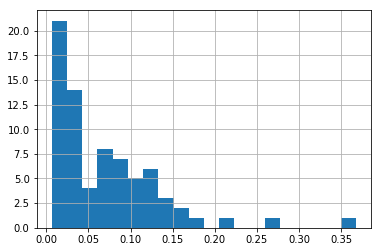

,count,percentage,rate
count,74.000000,74.000000,74.000000
mean,1488.527027,0.070981,0.200951
std,1365.691297,0.065124,0.027709
min,135.000000,0.006438,0.145553
25%,456.250000,0.021757,0.182831
50%,1064.000000,0.050738,0.198107
75%,2215.250000,0.105636,0.218118
max,7713.000000,0.367799,0.289412


In [185]:
nei_data = pd.DataFrame
data['Neighbourhood'].unique().size
nei_data = data.groupby('Neighbourhood')['PatientId'].count()
nei_data=nei_data.to_frame()
nei_data['percentage'] = data.groupby('Neighbourhood')['PatientId'].count()/data.size*100
nei_data['rate'] = data.groupby('Neighbourhood')['no_show'].sum()/  data.groupby('Neighbourhood')['no_show'].count()
nei_data = nei_data.sort_values(['percentage'], ascending=[1])

nei_data = nei_data.rename(index = str, columns={'PatientId':'count'})

nei_data = nei_data[nei_data['count']>100]
print(nei_data[:5])
print(nei_data[70::])
nei_data['percentage'].hist(bins=20)
plt.show()

nei_data.describe()

residual: 0.055976695232723875


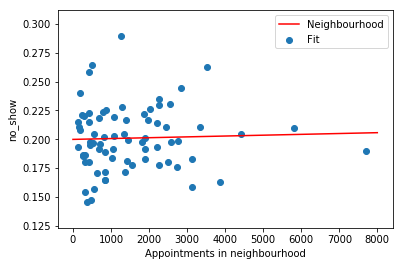

In [237]:

b,s,_,_,_ = np.polyfit(nei_data['count'].values, nei_data['rate'].values, deg=1, full=True)
plt.scatter(nei_data['count'],nei_data['rate'])
plt.plot(np.linspace(0,8000),np.multiply(np.linspace(0,8000),b[0])+b[1], color='red')
print('residual:',s[0])
plt.legend(['Neighbourhood','Fit'])
plt.xlabel('Appointments in neighbourhood')
plt.ylabel('no_show')
plt.show()


Most of the neighborhoods hold 0-0.05% of patients.

Maybe there's a connection between size and no_show rates

As expected, there's much more variance for lower numbers.
The no_show rate doesn't change with the size increase.

There is, however, a lot of unexpected noise - meaning that the neighhbourhood is a significant factor.
We just don't know how yet

One approach would be to code for neighbourhoods, but we don't have enough data from each neighbourhood

Idealy, we would use a map to cluster neighbourhoods according to their coordinates - assuming similar socio-economic status would behave similarly.
This could be done using google maps api, but is not a viable option for now.

What we can do is use the scholarship feature to classify the neighbourhoods. 



residual: 0.05456417204227074


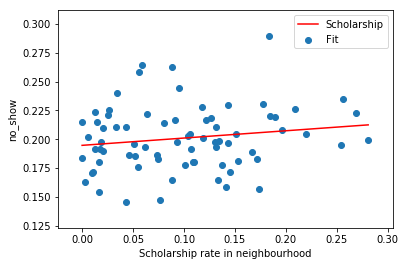

In [238]:
nei_data['scholarship'] = data.groupby('Neighbourhood')['Scholarship'].sum()/  data.groupby('Neighbourhood')['Scholarship'].count()
b,s,_,_,_ = np.polyfit(nei_data['scholarship'].values, nei_data['rate'].values, deg=1, full=True)
print('residual:',s[0])
plt.scatter(nei_data['scholarship'],nei_data['rate'])
plt.plot(np.linspace(0,nei_data['scholarship'].max()),np.multiply(np.linspace(0,nei_data['scholarship'].max()),b[0])+b[1], color='red')
plt.legend(['Scholarship','Fit'])
plt.xlabel('Scholarship rate in neighbourhood')
plt.ylabel('no_show')
plt.show()


no_show rates are higher for higher scholar neighbourhoods.
This may be just because scholars are more likely to not arrive. 

Let's check this

In [247]:
data.groupby('Scholarship')['no_show'].mean()

Scholarship
0    0.197898
1    0.237305
Name: no_show, dtype: float64

It shows the same affect as neighbourhood scholarship coding.  We can leave the scholarship feature as it is.

 ## PatientID

In [222]:
print('unique patients:',data['PatientId'].unique().size)

data.groupby('PatientId')['AppointmentID'].count().describe()


unique patients: 62210


count    62210.000000
mean         1.774184
std          1.770795
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
Name: AppointmentID, dtype: float64

There are 62210 patients.

the mean number of appointments is 1.77,
some patients have up to 88 appointments.

Let's look at the consistency of various patients

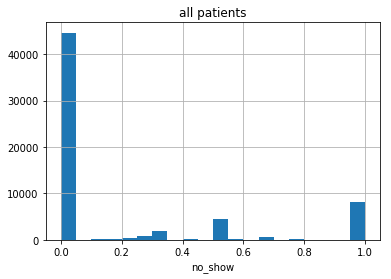

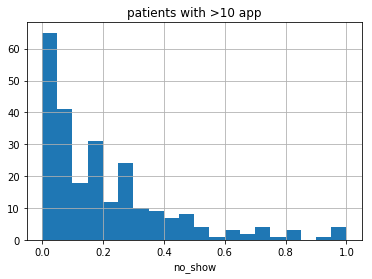

In [291]:
patient_data = data.groupby('PatientId')['Age'].count()
patient_data=patient_data.to_frame()
patient_data['rate'] = data.groupby('PatientId')['no_show'].mean()
patient_data = patient_data.sort_values('Age',ascending=False)
patient_data = patient_data.rename(index=str, columns={"Age": "count"})
patient_data[patient_data['count']>0].hist('rate',bins= 20)
plt.xlabel('no_show')
plt.title('all patients')
patient_data[patient_data['count']>10].hist('rate',bins= 20)
plt.xlabel('no_show')
plt.title('patients with >10 app')
plt.show()


Looking at patients with at least 10 appointments, a lot of them miss no or almost no appointments.  Some miss all of the appointments.

I'll add the rate and number of appointments to each patient


In [306]:
#print(patient_data['count'])
data['num_app'] = data.apply(lambda x:(patient_data['count'][x['PatientId']] ),axis=1)
data['patient_rate'] = data.apply(lambda x:(patient_data['rate'][x['PatientId']] ),axis=1)
data

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,SMS_received,no_show,is_male,age_code,app_day_code,sch_day_code,time_diff,time_diff_code,num_app,patient_rate
0,29872499824296.0,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,...,0,0,0,6,4,4,0,1,2,0.000000
1,558997776694438.0,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,...,0,0,1,6,4,4,0,1,2,0.000000
2,4262962299951.0,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,...,0,0,0,6,4,4,0,1,2,0.000000
3,867951213174.0,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,...,0,0,0,2,4,4,0,1,2,0.500000
4,8841186448183.0,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,...,0,0,0,6,4,4,0,1,1,0.000000
5,95985133231274.0,5626772,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,...,0,0,0,7,4,2,2,2,2,0.000000
6,733688164476661.0,5630279,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,...,0,1,0,4,4,2,2,2,1,1.000000
7,3449833394123.0,5630575,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,...,0,1,0,5,4,2,2,2,2,1.000000
8,56394729949972.0,5638447,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,...,0,0,0,3,4,4,0,1,1,0.000000
9,78124564369297.0,5629123,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,...,0,0,0,3,4,2,2,2,1,0.000000


residual: 0.26963678857543594


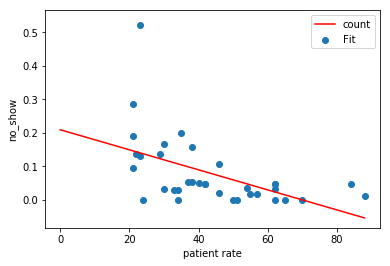

In [288]:
patient_data=patient_data[patient_data['count']>20]
b,s,_,_,_ = np.polyfit(patient_data['count'].values, patient_data['rate'].values, deg=1, full=True)
print('residual:',s[0])
plt.scatter(patient_data['count'],patient_data['rate'])
plt.plot(np.linspace(0,patient_data['count'].max()),np.multiply(np.linspace(0,patient_data['count'].max()),b[0])+b[1], color='red')
plt.legend(['count','Fit'])
plt.xlabel('patient rate')
plt.ylabel('no_show')
plt.show()
